In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x

In [ ]:
# exact solution of modelling coursework
def TransientAnalyticSoln(x, t):

    trans = 0
    for k in range(1, 1001):
        trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
    c = x + (2/np.pi)*trans
    return c

In [4]:
def Diffusion_Coeff(c):
  # constants
  D_ref = 2e-16
  c_max = 4.665e4
  C_theory = 277.84
  C_practical = 160

  # equations
  SOC = (c_max - c)/c_max * C_theory/C_practical
  D = D_ref * (1 + 100*SOC**(3/2))

  return D

0.000707486760802567
2.8622502146191664e-09
400000576.0


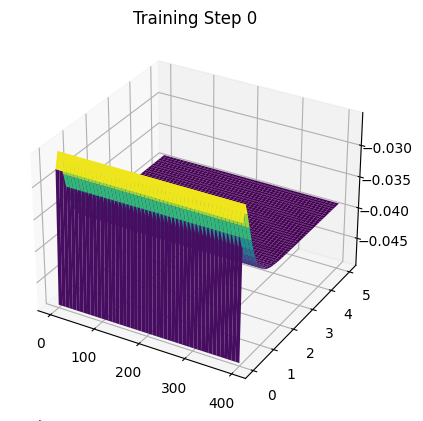

5.3421554184751585e-05
2401.0
399999424.0
0.0008640348678454757
2401.0
399998400.0
0.0030354761984199286
2401.0
399997568.0
0.006519804708659649
2401.0
399996544.0
0.011320963501930237
2401.0
399995552.0
0.01748841069638729
2401.0
399994528.0
0.025110293179750443
2401.0
399993504.0
0.034313615411520004
2401.0
399992480.0
0.04526958614587784
2401.0
399991456.0
0.05819898471236229
2401.0
399990400.0
0.07337572425603867
2401.0
399989376.0
0.09112989902496338
2401.0
399988064.0
0.11185208708047867
2401.0
399986720.0
0.13599976897239685
2401.0
399985472.0
0.16410616040229797
2401.0
399984000.0
0.1967908889055252
2401.0
399982592.0
0.23477286100387573
2401.0
399980992.0
0.27888402342796326


KeyboardInterrupt: 

In [5]:
# nn seed
torch.manual_seed(123)

# define nn to train, two inputs for x and t
pinn = Network(2, 3, 32, 1).to(device)

# parameters and things
Rs = 5e-6
j = -5.35e-5
C0 = 2e4
Cm = 4.665e4

# x and t boundary points for training x boundaries, x = 0,1, varying t values
r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
rs_boundary = torch.tensor(Rs).view(-1, 1).requires_grad_(True).to(device)
t_boundaries = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)

# 0 time boundary for training
t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
r_boundary = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)


# training things
epochs = 30000
lr = 1e-3
lambda1 = 1
lambda2 = 1

# optimiser
optimiser = torch.optim.Adam(pinn.parameters(), lr = lr)
losses = []

for e in range(epochs):

  optimiser.zero_grad()

  # x, t for phsyics loss
  r_physics = 5e-6 * torch.rand(100).requires_grad_(True).to(device)
  t_physics = 400 * torch.rand(100).requires_grad_(True).to(device)

  # r0 boundary loss
  outputs = torch.empty(0).to(device)
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(r0_boundary, t)
    c_r = torch.autograd.grad(c, r0_boundary, torch.ones_like(r0_boundary), create_graph = True)[0]
    outputs = torch.cat([outputs, c_r], dim = 0)

  r0_loss = torch.mean(outputs**2)
  print(r0_loss.item())

  # Rs boundary loss
  outputs = torch.empty(0).to(device)
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(rs_boundary, t)
    c_r = torch.autograd.grad(c, rs_boundary, torch.ones_like(rs_boundary), create_graph = True)[0]
    D = Diffusion_Coeff(c)
    outputs = torch.cat([outputs, D*c_r + j], dim = 0)

  Rs_loss = torch.mean((outputs)**2)
  print(Rs_loss.item())

  # t boundary loss
  outputs = torch.empty(0).to(device)
  for r in r_boundary:
    r = r.unsqueeze(1)
    c = pinn(r, t0_boundary)
    outputs = torch.cat([outputs, c_r], dim = 0)

  t_loss = torch.mean((outputs - C0)**2)
  print(t_loss.item())

  loss_phys_list = torch.empty(0).to(device)
  # physics loss function
  for i in range(len(r_physics)):
    r = r_physics[i].view(-1, 1)
    t = t_physics[i].view(-1, 1)

    c = pinn(r, t)
    c_r = torch.autograd.grad(c, r, torch.ones_like(r), create_graph = True)[0]
    c_rr = torch.autograd.grad(c_r, r, torch.ones_like(r), create_graph = True)[0]
    c_t = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    # find and store loss function
    D = Diffusion_Coeff(c)
    loss = r**2 * c_t - D*r**2*c_rr - 2*D*r*c_r
    loss_phys_list = torch.cat([loss_phys_list, loss], dim = 0)


  loss_phys = torch.mean(loss_phys_list**2)

  loss = lambda1 * (r0_loss + Rs_loss + t_loss) + lambda2 * loss_phys
  losses.append(loss.cpu().item())
  loss.backward()
  optimiser.step()

  if e % 5000 == 0:

    X = torch.linspace(0, 5e-6, 50)
    T = torch.linspace(0, 400, 50)
    cs = np.zeros((50, 50))

    for i, x in enumerate(X):
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        for j, t in enumerate(T):
            t = t.unsqueeze(0)
            t = t.unsqueeze(1)

            c = pinn(x, t)
            cs[i, j] = c


    X, T = np.meshgrid(X.numpy(), T.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(T, X, cs, cmap='viridis')

    plt.title(f"Training Step {e}")
    plt.show()

In [38]:
losses[1]

4000018.25

In [8]:
dcdxs = torch.zeros(12, 1)
dcdxs = torch.cat([dcdxs, dcdxs], dim = 0)
dcdxs

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])